In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

from utils.bigbord import bigbord

%load_ext autoreload
%autoreload 2


## Generate Fractal distribution of magnetization

This cell defines a function to generate a fractal distribution in 3D space, 
according to a given fractal scaling parameter
See for example Pilkington et al, 1994, Geophysical Prospecting


In [3]:
def fractal3(griddim,nlay,beta=-4,dx=1):

    nrow = griddim
    ncol = griddim

    # make random numbers with a lognormal distribution
    mu = 1
    sigma = 10**0.25
    data = 200 * np.exp(np.random.randn(nrow,ncol,nlay) * sigma + mu)

    data_trn = np.fft.fftshift(np.fft.fftn(data))

    kmax = (2*np.pi)/(dx*2)
    kxinc = kmax/(ncol/2)
    kyinc = kmax/(nrow/2)
    kzinc = kmax/(nlay/2)

    #% make grid of correctly scaled frequencies
    kx,ky,kz = np.meshgrid(np.arange(-kmax,kmax,kxinc),
                           np.arange(-kmax,kmax,kyinc),
                           np.arange(-kmax,kmax,kzinc)) 
    op = (kx**2+ky**2+kz**2)**(beta/4)
    #print(nrow/2,ncol/2,np.ceil(nlay/2.))
    op[int(nrow/2),int(ncol/2),int(np.ceil(nlay/2.))] = 0.

    data_trn_frctl = data_trn*op
    data_frctl = np.fft.ifftn(np.fft.ifftshift(data_trn_frctl))
    data_frctl = np.real(data_frctl)
    
    return data_frctl

## Magnetic Forward modelling functions

These functions are mostly python translations of subroutines from Blakely's textbook

There are also functions to compute radially-averaged power spectrum for a 2D magnetic anomaly map

In [4]:
def mlayer(mag,dx,z1,z2,mi,md,fi,fd):
    """
    % [mag] = mlayer(mag,dx,z1,z2,mi,md,fi,fd)
    %      matlab translation of Blakely subroutine
    %
    % subroutine mlayer(mag,nx,ny,dx,dy,z1,z2,mi,md,fi,fd,store)
    % c
    % c  Subroutine MLAYER calculates the total-field anomaly on a two-
    % c  dimensional grid due to a horizontal layer with two-
    % c  dimensional magnetization.  The following steps are involved:
    % c  (1) Fourier transform the magnetization, (2) multiply by the  
    % c  earth filter, and (3) inverse Fourier transform the product.   
    % c  Magnetization is specified on a rectangular grid with x and y  
    % c  axes directed north and east, respectively.  Z axis is down.  
    % c  Distance units irrelevant but must be consistent.  Requires 
    % c  subroutines FOURN, DIRCOS, KVALUE, and MFILT.  
    % c 
    % c  Input parameters:
    % c    nx - number of elements in the sout_to_north direction.  
    % c    ny - number of elements in the west-to-east direction.  
    % c         (NOTE:  both nx and ny must be a power of two.)
    % c    mag - a singly dimensioned real array containing the 
    % c         two-dimensional magnetization (in A/m).  Elements should 
    % c         be in order of west to east, then south to north (i.e., 
    % c         element 1 is southwest corner, element ny is 
    % c         southeast corner, element (nx-1)*ny+1 is northwest 
    % c         corner, and element ny*nx is northeast corner. 
    % c    store - a singly dimensioned real array used internally.  
    % c         It should be dimensioned at least 2*nx*ny. 
    % c    dx - sample interval in the x direction.
    % c    dy - sample interval in the y direction. 
    % c    z1 - depth to top of layer.  Must be > 0.
    % c    z2 - depth to bottom of layer.  Must be > z1.
    % c    mi - inclination of magnetization, in degrees positive below 
    % c         horizontal.
    % c    md - declination of magnetization, in degrees east of north.
    % c    fi - inclination of regional field.
    % c    fd - declination of regional field.
    % c
    % c  Output parameters:
    % c    mag - upon output, mag contains the total-field anomaly
    % c         (in nT) with same orientation as above.
    % c
    % complex cmag,mfilt,cmplx
    % real mag,mi,md,mx,my,mz,kx,ky
    % dimension mag(nx*ny),store(2*nx*ny),nn(2)
    % data pi/3.14159265/,t2nt/1.e9/
    """

    #% NB for matlab to agree with blakely definitions, need to transpose inputs
    #% then transpose again at the end
    mag = mag.T

    #print(np.arange(mag.shape[1]))
    newx, newy, mag = bigbord(np.arange(mag.shape[1]), np.arange(mag.shape[0]), mag)
    
    t2nt = 1e9    #% tesla to nanotesla??
    #%% IMPORTANT - the convention used by Blakely is for the x direction to be
    #%% North-South. This code retains that convention 
    nx,ny = mag.shape
    dy = dx

    #nn[0]=ny
    #nn[1]=nx
    #ndim=2
    [mx,my,mz] = dircos(mi,md,0)
    [fx,fy,fz] = dircos(fi,fd,0)
    #dkx=2.*pi/(nx*dx);  #% not used in matlab version
    #dky=2.*pi/(ny*dy); #% not used in matlab version
    
    store = np.fft.fft2(mag)

    kx,ky = kvalue(mag,dx,dy)
    kx,ky = np.meshgrid(kx,ky)
    mf = mfilt(kx,ky,mx,my,mz,fx,fy,fz,z1,z2)
    
    #print(mf)
    store = store*mf

    store = np.fft.ifft2(store)
    mag = np.real(store) * t2nt/(nx*ny)

    mag = mag[newx[0]:newx[1],newy[0]:newy[1]]
    
    mag = mag.T

    return mag


def dircos(incl,decl,azim):
    """
    %       subroutine dircos(incl,decl,azim,a,b,c)
    % c
    % c  Subroutine DIRCOS computes direction cosines from inclination
    % c  and declination.
    % c
    % c  Input parameters:
    % c    incl:  inclination in degrees positive below horizontal.  
    % c    decl:  declination in degrees positive east of true north.  
    % c    azim:  azimuth of x axis in degrees positive east of north.
    % c
    % c  Output parameters:
    % c    a,b,c:  the three direction cosines.
    % c
    %       real incl
    %       data d2rad/.017453293/
    """
    xincl=np.radians(incl)
    xdecl=np.radians(decl)
    xazim=np.radians(azim)
    a=np.cos(xincl)*np.cos(xdecl-xazim)
    b=np.cos(xincl)*np.sin(xdecl-xazim)
    c=np.sin(xincl)

    return a,b,c


def mfilt (kx,ky,mx,my,mz,fx,fy,fz,z1,z2):
    """
    %       function mfilt(kx,ky,mx,my,mz,fx,fy,fz,z1,z2)
    % c
    % c  Function MFILT calculates the complex value of the earth 
    % c  filter at a single (kx,ky) location.
    % c
    % c  Input parameters:
    % c    kx - the wavenumber coordinate in the kx direction.
    % c    ky - the wavenumber coordinate in the ky direction.
    % c    mx - the x direction cosine of the magnetization vector.
    % c    my - the y direction cosine of the magnetization vector.
    % c    mz - the z direction cosine of the magnetization vector.
    % c    fx - the x direction cosine of the regional field vector.
    % c    fy - the y direction cosine of the regional field vector.
    % c    fz - the z direction cosine of the regional field vector.
    % c    z1 - the depth to the top of the layer.
    % c    z2 - the depth to the bottom of the layer.
    % c
    % c  Output parameters:
    % c    mfilt - the complex value of the earth filter.
    % c
    %       complex mfilt,thetam,thetaf,cmplx
    %       real kx,ky,k,mx,my,mz
    %       data pi/3.14159265/,cm/1.e-7/
    """

    cm = 1e-7
    k = np.sqrt(kx**2+ky**2)
    thetam = mz + 1j * (kx*mx+ky*my)/k
    thetaf = fz + 1j * (kx*fx+ky*fy)/k
    mf = 2*np.pi*cm*thetam*thetaf*(np.exp(-k*z1)-np.exp(-k*z2))
    mf[k==0] = 0;

    return mf


def kvalue(data,dx,dy=None):
    """
    % c  Subroutine KVALUE finds the wavenumber coordinates of one 
    % c  element of a rectangular grid from subroutine FOURN.  
    % c
    % c  Input parameters:
    % c    i  - index in the ky direction.
    % c    j  - index in the kx direction.
    % c    nx - dimension of grid in ky direction (a power of two).
    % c    ny - dimension of grid in kx direction (a power of two).
    % c    dkx - sample interval in the kx direction.
    % c    dky - sample interval in the ky direction.
    % c
    % c  Output parameters:
    % c    kx - the wavenumber coordinate in the kx direction.
    % c    ky - the wavenumber coordinate in the ky direction.
    % c
    """
    if not dy:
        dy = dx

    ny,nx = data.shape
    i=np.arange(ny)
    j=np.arange(nx)
    dkx = (2*np.pi)/(nx*dx)
    dky = (2*np.pi)/(ny*dy)

    nyqx=nx/2+1
    nyqy=ny/2+1

    kx = np.zeros_like(j, dtype=np.double)
    ky = np.zeros_like(i, dtype=np.double)
    ind = j<nyqx
    kx[ind] = j[ind] * dkx
    ind = j>=nyqx
    kx[ind] = (j[ind]-nx) * dkx

    ind = i<nyqy
    ky[ind] = i[ind] * dky
    ind = i>=nyqy
    ky[ind] = (i[ind]-ny) * dky
    
    return kx,ky
    

def spec2(mag):

    T = np.fft.fft2(mag)
    S = T * np.conj(T)
    return np.fft.fftshift(S)


def rpsinterp(S,dx):
    """
    % [Sra,dr,Rs] = rps (S,dx)
    %   Sra is the Radially Averaged Power Spectrum of the spectrum S, evaluated at points
    %   along lines extending radially outwards from the centre of the 2D spectrum at, at 1
    %   degree increments. Linear interpolation is used to map spectrum onto these points. The
    %   radial wavenumber increment is given by dr (in radians/distance unit), based on the
    %   input data spacing dg
    % see also RPSBIN
    """

    ny,nx = S.shape
    nr = int(np.floor(np.min((nx,ny))/2))
    na = int(360)   #%% number of angles - hardwired in to code, could be altered??

    R = np.zeros((na,nr))
    dr = 2*np.pi/(dx*(nx-1))
    Rad = np.tile(np.arange(0,nr),(na,1))      # points onto which we will sample radial spectrum,
                                  # defined by angle and distance from
                                  # centre of spectrum
    da = 2*np.pi/(na);
    A = np.tile(da*np.arange(0,na), (nr,1)).T
    
    nx2 = np.floor(nx/2)
    ny2 = np.floor(ny/2)
    if is_odd(nx):
        Wx=np.arange(-nx2,nx2+1) 
    else: 
        Wx=np.arange(-nx2,nx2)
    if is_odd(ny): 
        Wy=np.arange(-ny2,ny2+1)
    else: 
        Wy=np.arange(-ny2,ny2)

    Vxi = Rad*np.cos(A)
    Vyi = Rad*np.sin(A)
    #% NB in next line, switched Vxi and Vyi so that Angular spectrum starts at
    #% 0 degrees
    f = interpolate.RectBivariateSpline(Wx,Wy,S)
    Rs = f.ev(Vyi,Vxi)
    #Rs = interp2(Wx,Wy,S,Vyi,Vxi);      #%% Rs is the radial spectrum

    #%%% Rla is the Radially Averaged Spectrum - note take the log first then avarage,
    #%%% as proposed by Maus and Dimri
    Sra = np.sum(np.log(np.abs(Rs)), axis=0) / Rs.shape[0]

    return Sra,dr,Rs


def is_odd(num):
    return num & 0x1


def cosine_filter(mag, dx, cuts, highpass=True):
    dy=dx
    store = np.fft.fft2(mag)
    kx,ky = kvalue(mag,dx,dy)
    kx,ky = np.meshgrid(kx,ky)
    
    k = np.sqrt(kx**2+ky**2)
    filter_response = design_cosine_filter(k, cuts)
    
    if highpass:
        filter_response = (filter_response-1) * -1
    
    store = np.fft.ifft2(store * filter_response)
    
    return np.real(store)

    
    

## Example Application

Based on the example in Pilkington and Cowan (2006), Geophysics (though actually a bit simpler, we don't use a true 3D distribution of magnetization but instead two layers of limited depth-extent where the magnetiation varies in x and y but not z)

We define the same two layers, where
- layer one is from 1000-3000 m depth
- layer two is from 6000-22000 m depth

Magnetizing field is vertical for simplicity

/var/folders/k2/jz_0twls1q13vbr87bqwdtr40000gn/T/ipykernel_1192/664279344.py:147: RuntimeWarning: invalid value encountered in true_divide
  thetam = mz + 1j * (kx*mx+ky*my)/k
/var/folders/k2/jz_0twls1q13vbr87bqwdtr40000gn/T/ipykernel_1192/664279344.py:148: RuntimeWarning: invalid value encountered in true_divide
  thetaf = fz + 1j * (kx*fx+ky*fy)/k


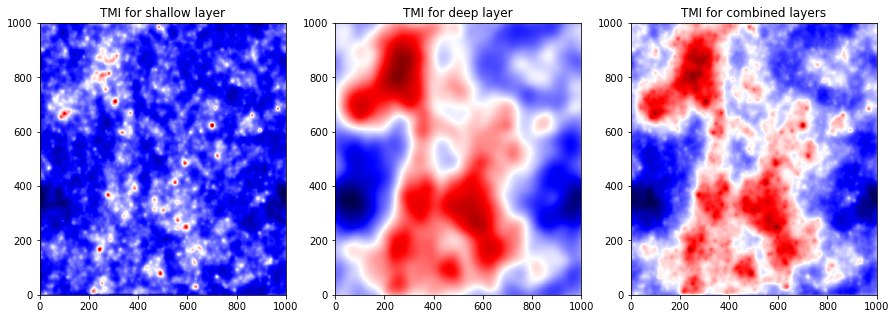

In [20]:
griddim = 1000  # number of grid nodes in x and y direction (Assume a square area)
nlay = 2
beta = -3   # fractal scaling parameter
dx = 200    # spacing between grid points, in metres

layer1_top = 1000.
layer1_bottom = 3000.

layer2_top = 6000.
layer2_bottom = 22000.

# This number controls the factor by which we assume the magnetization of the deep layer is greater than that of the shallow layer
# (making this number larger will generally make the separation more tractable)
deep_layer_multipication_factor = 1.



# Generate a 3D array as a function of (x,y,depth)
data_frctl = fractal3(griddim,nlay,beta);


res1 = mlayer(data_frctl[:,:,0], dx, layer1_top, layer1_bottom, 90, 0, 90, 0)
res2 = mlayer(data_frctl[:,:,1], dx, layer2_top, layer2_bottom, 90, 0, 90, 0) * deep_layer_multipication_factor


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
p1 = ax[0].pcolormesh(res1, cmap='seismic')
ax[0].set_title('TMI for shallow layer')
p2 = ax[1].pcolormesh(res2, cmap='seismic')
ax[1].set_title('TMI for deep layer')
p2 = ax[2].pcolormesh(res1+res2, cmap='seismic')
ax[2].set_title('TMI for combined layers')
plt.show()

## Comparison of layer responses in wavenumber domain

/opt/anaconda3/envs/pygmt4/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  nx, tx, ny, ty, c, fp, ier = dfitpack.regrid_smth(x, y, z, xb, xe, yb,


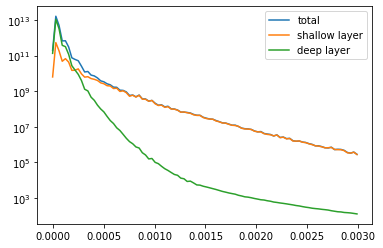

In [21]:
s = spec2(res1 + res2)
Sra,dr,Rs = rpsinterp(s,dx)

Sra1,dr,Rs1 = rpsinterp(spec2(res1),dx)

Sra2,dr,Rs1 = rpsinterp(spec2(res2),dx)

wavenumber_scale = np.arange(len(Sra))*dr
ind = wavenumber_scale<0.003

#plt.pcolormesh(np.log(np.abs(s)))
#plt.show()

plt.semilogy(wavenumber_scale[ind], np.exp(Sra)[ind], label='total')
plt.semilogy(wavenumber_scale[ind], np.exp(Sra1)[ind], label='shallow layer')
plt.semilogy(wavenumber_scale[ind], np.exp(Sra2)[ind], label='deep layer')
#plt.xlim(0,0.003)
#plt.ylim(1e2, 1e12)
plt.legend()
plt.show()

(0.0, 0.001)

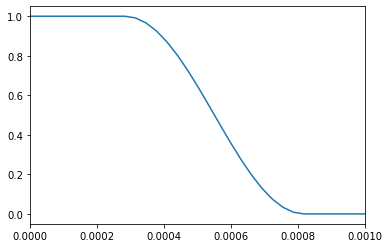

In [188]:
def design_cosine_filter(wavenumber_scale, cuts):
    cut_one = np.min(cuts)
    cut_zero = np.max(cuts)

    filter_response = np.zeros_like(wavenumber_scale)
    filter_response[wavenumber_scale>cut_zero] = np.pi

    ind = (wavenumber_scale>cut_one) & (wavenumber_scale<cut_zero)

    filter_response[ind] = np.linspace(0,np.pi,np.count_nonzero(ind)+2)[1:-1]
    filter_response = (np.cos(filter_response)+1.)/2.
    
    return filter_response
    
design_cosine_filter(wavenumber_scale, (0.0003, 0.0008))
plt.plot(wavenumber_scale, filter_response)
plt.xlim(0,0.001)


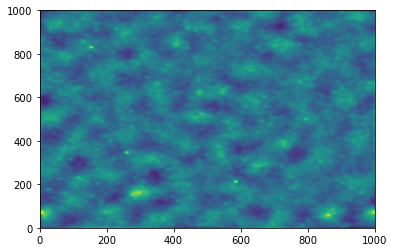

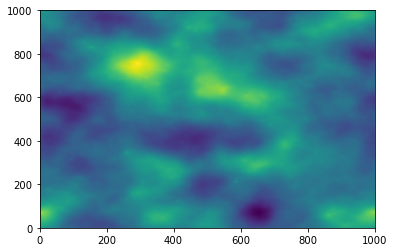

In [221]:
f = cosine_filter(res1 + res2, dx, (0.0002, 0.0008), highpass=True)

plt.pcolormesh(f)
plt.show()
plt.pcolormesh(res1 + res2)
plt.show()